Index(['age', 'body_type', 'drinks', 'drugs', 'education', 'ethnicity',
       'height', 'job', 'location', 'orientation', 'sex', 'sign', 'smokes',
       'speaks', 'status', 'signs_clean'],
      dtype='object')


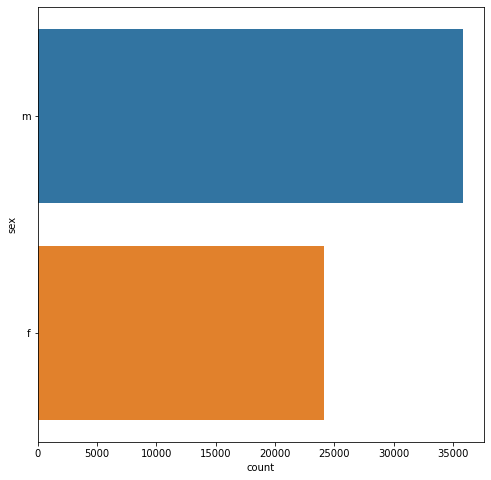

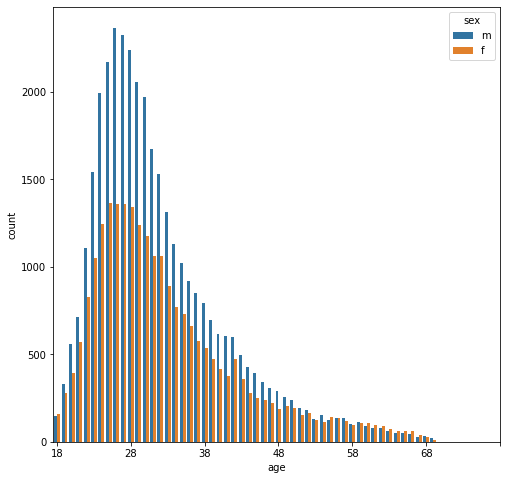

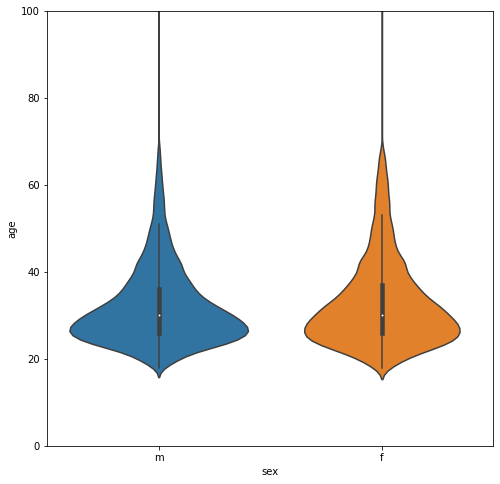

         age                                                     
       count       mean        std   min   25%   50%   75%    max
sex                                                              
f    24117.0  32.818220  10.025385  18.0  26.0  30.0  37.0  110.0
m    35829.0  32.018588   9.032881  18.0  26.0  30.0  36.0  109.0


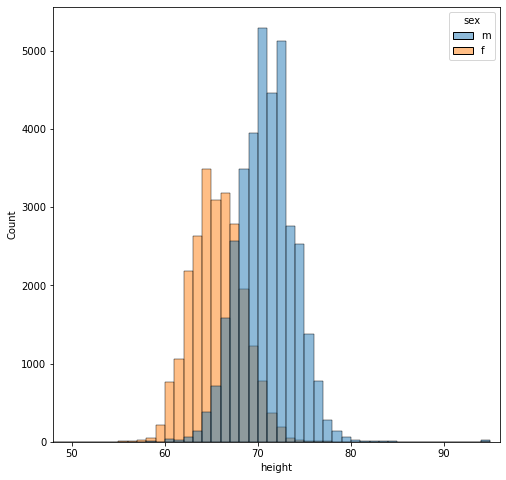

      height                                                  
       count       mean       std  min   25%   50%   75%   max
sex                                                           
f    24116.0  65.103873  2.926502  4.0  63.0  65.0  67.0  95.0
m    35827.0  70.443492  3.076521  1.0  68.0  70.0  72.0  95.0


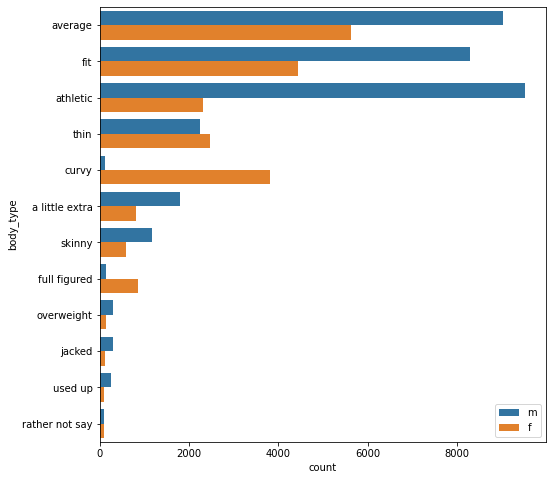

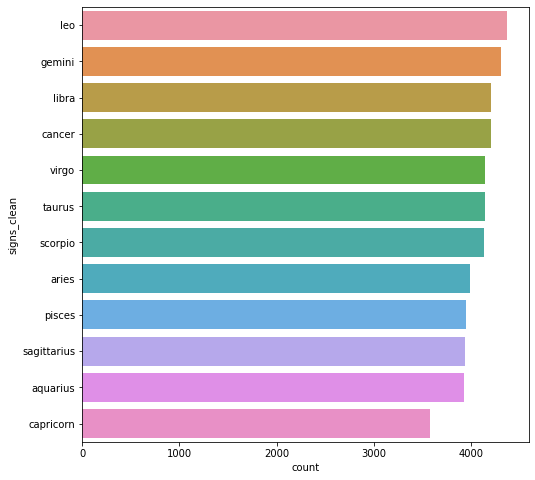

<Figure size 576x576 with 0 Axes>

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = [8,8]

#Import data
raw_df = pd.read_csv("profiles.csv")
#print(raw_df.head())
#print(raw_df.describe())
#print(raw_df.columns)

#Cleanse raw data of essay questions
no_essay_df = raw_df.drop(raw_df.loc[:, 'essay0':'essay9'].columns, axis = 1)
essay_df = raw_df.filter(like = "essay")
#print(no_essay_df.columns)
#print(essay_df.columns)

#Drop columns with less than 75% complete data
complete_df = no_essay_df.drop(["diet", "offspring", "income", "pets", "religion", "last_online"], axis = 1)
complete_df_nona = complete_df.dropna()
#print(complete_df.columns)
#print(len(complete_df), len(complete_df_nona))

#Clean "Signs" column
complete_df["signs_clean"] = complete_df["sign"].str.split().str.get(0)
#print(complete_df["signs_clean"].unique())

#Remapping "smokes"
#print(complete_df["smokes"].unique())
complete_df["smokes"] = complete_df["smokes"].replace(to_replace = ["sometimes", "when drinking", "trying to quit"], value = "yes")
#print(complete_df["smokes"].unique())

print(complete_df.columns)

#See column value counts
def column_value_counts(dataframe):
    for column in dataframe.columns:
        #print(column)
        print(dataframe["{}".format(column)].value_counts(dropna = False) )
        print("Proportion of complete entries: ", len(dataframe["{}".format(column)].dropna())/len(dataframe))
        print()
#column_value_counts(raw_df)
#column_value_counts(no_essay_df)
#column_value_counts(complete_df)
#column_value_counts(complete_df_nona)

#Building some introductory graphs
#Gender counts
sns.countplot(data = complete_df, y = "sex")
plt.show()
plt.clf()
#Age histogram by sex
sns.countplot(data = complete_df, x = "age", hue = "sex")
plt.xticks(np.arange(0, 70, 10))
plt.show()
plt.clf()
#Age violinplot by sex
sns.violinplot(data = complete_df, x = "sex", y = "age")
ax = plt.axes()
ax.set_ylim([0, 100])
plt.show()
plt.clf()
print(complete_df[["age", "sex"]].groupby(["sex"]).describe())

#Height histogram by sex
sns.histplot(data = complete_df, x = "height", hue = "sex", alpha = 0.5, binwidth = 1)# multiple = "dodge"
ax2 = plt.axes()
ax2.set_xlim([48, 96])
plt.show()
plt.clf()
print(complete_df[["height", "sex"]].groupby(["sex"]).describe())

#Body type by sex
sns.countplot(data = complete_df, y = "body_type", hue = "sex", order = complete_df.body_type.value_counts().index) #Ordered highest to lowest
plt.legend(loc = "lower right")
plt.show()
plt.clf()

#Zodiac signs 
sns.countplot(data= complete_df, y = "signs_clean", order = complete_df.signs_clean.value_counts().index) #Ordered highest to lowest
plt.show()
plt.clf()



In [11]:
#Objective: Classify "smokes"

#Pre-processing data

cols = ["age", "body_type", "drinks", "drugs", "job", "sex", "signs_clean", "smokes"]
df_smoker_input = complete_df[cols].dropna()
#print(df_smoker_input.head())
for col in cols[:-1]:
    df_smoker_input = pd.get_dummies(df_smoker_input, columns=[col], prefix = [col])
#print(df_smoker_input.head())


#Splitting data

col_length = len(df_smoker_input.columns)
#X is predictor columns, Y is column to predict
y = df_smoker_input.iloc[:, 0]
y.replace("yes", 1, inplace = True)
y.replace("no", 0, inplace = True)
#y = y.map(dict(yes = 1, no = 0))
x = df_smoker_input.iloc[:, 1:col_length]
#print( y.value_counts(dropna = False))

from sklearn.model_selection import train_test_split
validation_size = 0.2
x_train, x_labels, y_train, y_labels = train_test_split(x, y, test_size = validation_size)

#turn in to 1d arrays
y_train = y_train.to_numpy().ravel()
y_labels = y_labels.to_numpy().ravel()



LOGIT MODEL
             precision    recall  f1-score   support

          0       0.85      0.96      0.90     19687
          1       0.62      0.27      0.38      4750

avg / total       0.80      0.83      0.80     24437

KNN MODEL
             precision    recall  f1-score   support

          0       0.84      0.98      0.90     19687
          1       0.71      0.21      0.32      4750

avg / total       0.81      0.83      0.79     24437

DECISION TREE MODEL
             precision    recall  f1-score   support

          0       0.89      0.97      0.93     19687
          1       0.82      0.52      0.64      4750

avg / total       0.88      0.88      0.87     24437



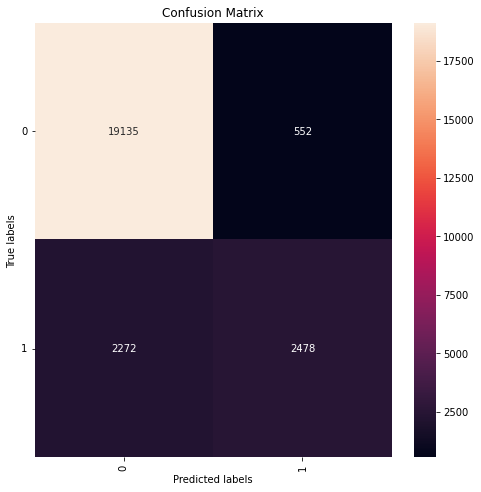

In [15]:
#Prediction Time!

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

#LOGIT model
logit = LogisticRegression(multi_class= "multinomial", solver = "newton-cg")
logit.fit(x_train, y_train)
logit_predictions = logit.predict(x_train)
print("LOGIT MODEL")
print(classification_report(y_train, logit_predictions))


#KNN model
'''
#Finding max K for 1<k<20 neighbors:
k_scores = []
max_score, max_k = 0, 0
for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    k_scores.append(knn.score(x_labels, y_labels))
    if knn.score(x_labels, y_labels) > max_score:
        max_score = knn.score(x_labels, y_labels)
        max_k = k
print(max_score, max_k)
#max_score = max(k_scores)
k_list = range(1,20)
plt.plot(k_list, k_scores)
plt.show()
'''
#max k = 0.81, n_neighbors = 10
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)
knn_predictions = knn.predict(x_train)
print("KNN MODEL")
print(classification_report(y_train, knn_predictions))


#Decision Tree model
tree_model = DecisionTreeClassifier(max_depth = 20)
tree_model.fit(x_train, y_train)
tree_predictions = tree_model.predict(x_train)
print("DECISION TREE MODEL")
print(classification_report(y_train, tree_predictions))

from sklearn.metrics import confusion_matrix
tree_cm = confusion_matrix(y_train, tree_predictions)
tree_labels = tree_model.classes_
ax3 = plt.subplot()
sns.heatmap(tree_cm, annot=True, ax = ax3,fmt="d")
# labels, title and ticks
ax3.set_xlabel('Predicted labels');
ax3.set_ylabel('True labels'); 
ax3.set_title('Confusion Matrix');
ax3.yaxis.set_tick_params(rotation=360)
ax3.xaxis.set_tick_params(rotation=90)

ax3.xaxis.set_ticklabels(tree_labels); 
ax3.yaxis.set_ticklabels(tree_labels);

#.get_depth()